<a href="https://colab.research.google.com/github/timalsinab/Bishal/blob/master/L03_Grid_Approx_f25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L03: Grid Approximation TSP](https://docs.google.com/document/d/1L8J0AKVoiDuaLXy4FjzH9eGUq8B4W-kQWj6eoGL0G40/edit?usp=sharing)

Written by Dr. Jan Pearce, Berea College

Content Edited by Dr. Mario Nakazawa, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: Bishal

# **SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

At first, my plan was just to get a simple greedy or nearest-neighbor TSP running, but as I read more about the grid approximation idea, I realized it needed recursion and tour merging. I started small, testing base cases with 4–5 nodes and then expanded to larger inputs. It took a while to figure out how to combine the tours correctly, but once that worked, the algorithm could handle any dataset and show the route visually. In total, I spent a few days working on it, mostly debugging and testing the recursive parts.

**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

I worked on this project alone, but I looked at some past examples and discussed ideas about the grid-based splitting with a few classmates. All the implementation and testing were done by me.

**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

The hardest part was getting the recursion and combineTours function to actually produce a full valid tour without breaking connections. At first, the program would miss nodes or repeat them, which made it frustrating to debug. It also took time to understand how to decide when to split horizontally or vertically.

**INNOVATIONS**: Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

I made sure my program printed and plotted the total distance each time and added an automatic route validation check so I could see if the tour was valid. It wasn’t required, but it helped a lot while testing.

**TESTING**: Describe how you tested this work.

I tested my code on the small TSP datasets and random inputs created by the helper function. I also tested a simple 4-point square to make sure the route and distance made sense. Each time I ran the program, I compared the visual graph with the printed tour order to confirm that everything matched.

**ERRORS**: A list in bulleted form of all known errors and deficiencies.

Sometimes the route may not be the shortest possible since this is just an approximation.

When nodes are aligned too closely or overlap, the graph labels can look messy.

The performance slows down slightly for very large inputs.

**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab.

Overall, this lab was challenging but pretty fun once I started seeing the graphs form correct paths. I learned a lot about recursion, partitions, and how combining smaller problems can solve a big one. It felt good to see the final tour drawn with all distances displayed.

## Import Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
import random
import itertools

### Read data

In [7]:
def get_new_node_coords(numnodes, scale=1):
    nodeStr = f'{numnodes}\n'
    coords = []
    for i in range(numnodes):
        x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        while (x, y) in coords:
            x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        coords.append((x, y))
        nodeStr += f'{x} {y}\n'
    return nodeStr


# tspdata = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-48.txt").read().decode('ASCII')
tspdata = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-small.txt").read().decode('ASCII')
# tspdata = get_new_node_coords(20)
print(tspdata)

6
1 5 
3 7 
5 11 
3 5 
5 7 
7 9 



## TSP Class

Tour: [0, 1, 2, 5, 4, 3, 0]
Total Distance: 17.79


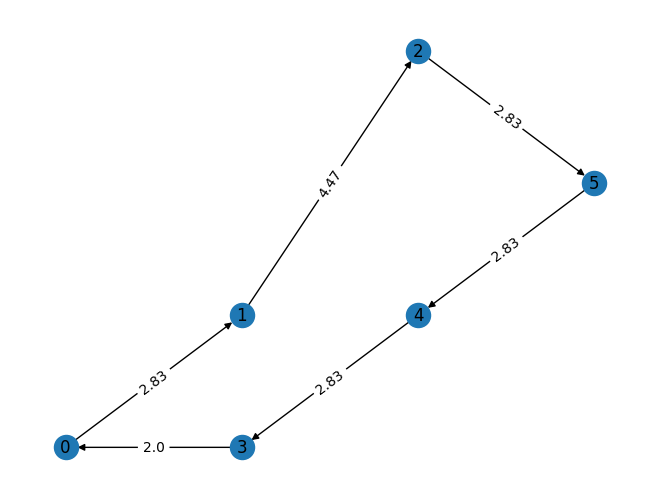

In [8]:
"""

Given certain input, it uses the grid approximation algorithm to plot a graph and output a file of the solution path
"""

class TSP:

    def __init__(self):
        """ TSP class containing data needed for networkx graph creation, file reading and file writing.
            Creates a graph for the traveling salesperon problem
        """

        self.dimension = None
        self.nodeData = []
        self.graph = nx.DiGraph()
        self.coords = {}
        self.route = []

    def extractData(self, inputFile=""):
        """ Iterates through the input file and append each coordinate into the node list.
        Keyword Arguments:
            inputFile {str} -- a string for the file name (default: {""})
        """
        WTSPC = ['\n', '\r', '\t', ' ']
        inputData = inputFile.split()
        cleanData = [int(i) for i in inputData if i not in WTSPC]

        self.dimension = cleanData[0]

        for i in range(1, len(cleanData), 2):
            nodeX = cleanData[i]
            nodeY = cleanData[i + 1]
            self.nodeData.append([nodeX, nodeY])

    def setUpCoords(self):
        """ Puts the coordinates for each node into a dictionary as a tuple with the node as the key """
        for i in range(len(self.nodeData)):
            self.coords[i] = self.nodeData[i]

    def getDirection(self, a, b, c):
        """ Determines if the angle made by the path a-b-c is clockwise or
            couter clockwise
        Arguments:
            a {int} -- the integer index of a node
            b {int} -- the integer index of a node
            c {int} -- the integer index of a node
        Returns:
            {int} -- 1 if a->b->c is clockwise, -1 if counterclockwise
        """
        ax, ay = self.coords[a][0], self.coords[a][1]
        bx, by = self.coords[b][0], self.coords[b][1]
        cx, cy = self.coords[c][0], self.coords[c][1]
        val = (by-ay)*(cx-bx)-(bx-ax)*(cy-by)
        if val < 0:
            return -1
        elif val > 0:
            return 1
        return 0

    def calculateDistance(self, a, b):
        """ Calculates & returns the distance between points a and b
        Arguments:
            a {tuple (int)} -- tuple of numbers for the x and y coordinate of a node
            b {tuple (int)} -- tuple of numbers for the x and y coordinate of a node
        Returns:
            {float} -- the distance between the two points using the distance formula
        """
        x1 = float(a[0])
        y1 = float(a[1])
        x2 = float(b[0])
        y2 = float(b[1])
        xSquared = math.pow(x2 - x1, 2)
        ySquared = math.pow(y2 - y1, 2)
        c = round(math.sqrt(xSquared + ySquared), 2)
        return c

    def calculateTotalDistance(self, route=None):
        """
        """
        if route == None:
            route = self.route

        total = 0
        for i in range(len(route) - 1):
            n1 = self.coords[route[i]]
            n2 = self.coords[route[i+1]]
            total += self.calculateDistance(n1, n2)
        return total

    def getAllTours(self, nodes):
        """ Calculates all possible tours using nodes from 'nodes'
        Arguments:
            nodes {list (int)} -- List of node numbers
        Returns:
            A list of tuples, each tuple representing a single tour
        """
        tours = list(itertools.permutations(nodes))
        return [list(t) + [t[0]] for t in tours]

    def isClockwise(self, route):
        """ Decides if a route contains only clockwise angles
            NOTE: If route is of size 5, there can be a single angle that is
            the opposite of the others.
        Arguments:
            route {list (int)} -- List of node numbers on route
        Returns:
            {bool} True if all angles are clockwise, False otherwise
        """
        edges = [(route[i], route[i+1], route[i+2]) for i in range(len(route) - 2)]
        return all([self.getDirection(a, b, c) in [0, 1] for (a, b, c) in edges])

    def isCounterclockwise(self, route):
        """ Decides if a route contains only counterclockwise angles
            NOTE: If route is of size 5, there can be a single angle that is
            the opposite of the others.
        Arguments:
            route {list (int)} -- List of node numbers on route
        Returns:
            {bool} True if all angles are clockwise, False otherwise
        """
        edges = [(route[i], route[i+1], route[i+2]) for i in range(len(route) - 2)]
        return all([self.getDirection(a, b, c) in [0, -1] for (a, b, c) in edges])

    def horizontalPartition(self, nodes, xval):
        """ Splits the list 'nodes' into two lists, left and right, such that
            all nodes in 'left' have an x-coordinate less than or equal to
            xval, and all nodes in 'right' have an x-coordinate greater than or
            equal to xval.

            *** NOTE: THIS DOES NOT BREAK TIES.  ANY NODE WITH AN X-COORDINATE
            EQUAL TO XVAL WILL GO TO BOTH LISTS.  YOU MUST DECIDE HOW TO
            BREAK THE TIE.
        Arguments:
            nodes {list (int)} -- the list of nodes to partition
            xval {int} -- the x-coordinate boundary between partitions
        Returns:
            Two lists of ints, 'left' and 'right'.  If any nodes lie on the
            boundary, they will be included in both lists.
        """
        bounds = self.getBounds(list(range(self.graph.number_of_nodes())))
        xmin, xmax = bounds['xmin'], bounds['xmax']
        ymin, ymax = bounds['ymin'], bounds['ymax']

        left = self.getNodesBetween(nodes, xmin, xval, ymin, ymax)
        right = self.getNodesBetween(nodes, xval, xmax, ymin, ymax)
        return left, right

    def verticalPartition(self, nodes, yval):
        """ Splits the list 'nodes' into two lists, top and bottom, such that
            all nodes in 'top' have a y-coordinate greater than or equal to
            yval, and all nodes in 'bottom' have a y-coordinate less than or
            equal to yval.

            *** NOTE: THIS DOES NOT BREAK TIES.  ANY NODE WITH A Y-COORDINATE
            EQUAL TO YVAL WILL GO TO BOTH LISTS.  YOU MUST DECIDE HOW TO
            BREAK THE TIE.
        Arguments:
            nodes {list (int)} -- the list of nodes to partition
            yval {int} -- the y-coordinate boundary between partitions
        Returns:
            Two lists of ints, 'top' and 'bottom'.  If any nodes lie on the
            boundary, they will be included in both lists.
        """
        bounds = self.getBounds(list(range(self.graph.number_of_nodes())))
        xmin, xmax = bounds['xmin'], bounds['xmax']
        ymin, ymax = bounds['ymin'], bounds['ymax']

        top = self.getNodesBetween(nodes, xmin, xmax, yval, ymax)
        bottom = self.getNodesBetween(nodes, xmin, xmax, ymin, yval)
        return top, bottom

    def getBounds(self, nodes):
        """ Gets the bounding box containing every node in 'nodes'
        Arguments:
            nodes {list (int)} -- List of node numbers to bound
        Returns:
            dict {(str) : (int)} mapping the strings 'xmax', 'xmin', 'ymax', 'ymin'
            to the corresponding bounding values
        """
        allcoords = [self.coords[i] for i in nodes]
        myx = [i[0] for i in allcoords]
        myy = [i[1] for i in allcoords]
        return {'xmax': max(myx), 'xmin': min(myx),
                'ymax': max(myy), 'ymin': min(myy)}

        # To use this elsewhere in the code, do something like:
        # bounds = self.getBounds([0, 1, 2, 3, 4])
        # my_minimum_x_value = bounds['xmin']
        # my_maximum_y_value = bounds['ymax']

    def getNodesBetween(self, nodes, xmin, xmax, ymin, ymax):
        """ Returns all nodes within the specified bounding box
        Argments:
            nodes {list (int)} -- the list of nodes to search within
            xmin {int} -- The minimum x-value for any node
            xmax {int} -- The maximum x-value for any node
            ymin {int} -- The minimum y-value for any node
            ymax {int} -- The maximum y-value for any node
        Returns:
            {list (int)} -- A list of node numbers that fall within the
            specified bounding box
        """
        ret = []
        for i in nodes:
            myx = self.coords[i][0]
            myy = self.coords[i][1]
            if (xmin <= myx <= xmax) and (ymin <= myy <= ymax):
                ret.append(i)
        return ret

    def gridApprox(self, currentNodes=None):
        """ Uses the grid approximation algorithm. Gets the route order and
            adds the starting place to the end of the route.
        Keyword Arguments:
            currentNodes {list (int)} -- the list of node indexes within the
            current segment of the grid.  If no value is provided, currentNodes
            is assigned the set of all nodes in the graph.
        """
        top_level = False
        if currentNodes is None:
            currentNodes = list(range(self.graph.number_of_nodes()))
            top_level = True
        if len(currentNodes) <= 5:
            best_tour, best_cost = None, float('inf')
            for tour in self.getAllTours(currentNodes):
                if self.isClockwise(tour):
                    cost = self.calculateTotalDistance(tour)
                    if cost < best_cost:
                        best_tour, best_cost = tour, cost
            if best_tour is None:
                for tour in self.getAllTours(currentNodes):
                    cost = self.calculateTotalDistance(tour)
                    if cost < best_cost:
                        best_tour, best_cost = tour, cost
            if top_level:
                self.route = best_tour
            return best_tour
        bounds = self.getBounds(currentNodes)
        xmin, xmax = bounds['xmin'], bounds['xmax']
        ymin, ymax = bounds['ymin'], bounds['ymax']
        width, height = xmax - xmin, ymax - ymin
        if width >= height:
            xmid = (xmin + xmax) / 2.0
            left = [n for n in currentNodes if self.coords[n][0] <= xmid]
            right = [n for n in currentNodes if self.coords[n][0] > xmid]
            split_type = 'horizontal'
            if not left or not right:
                ymid = (ymin + ymax) / 2.0
                top = [n for n in currentNodes if self.coords[n][1] >= ymid]
                bottom = [n for n in currentNodes if self.coords[n][1] < ymid]
                if top and bottom:
                    t1 = self.gridApprox(top)
                    t2 = self.gridApprox(bottom)
                    result = self.combineTours(t1, t2, split='vertical')
                    if top_level:
                        self.route = result
                    return result
                sorted_x = sorted(currentNodes, key=lambda n: self.coords[n][0])
                mid = len(sorted_x)//2
                left, right = sorted_x[:mid], sorted_x[mid:]
        else:
            ymid = (ymin + ymax) / 2.0
            top = [n for n in currentNodes if self.coords[n][1] >= ymid]
            bottom = [n for n in currentNodes if self.coords[n][1] < ymid]
            split_type = 'vertical'
            if not top or not bottom:
                xmid = (xmin + xmax) / 2.0
                left = [n for n in currentNodes if self.coords[n][0] <= xmid]
                right = [n for n in currentNodes if self.coords[n][0] > xmid]
                if left and right:
                    t1 = self.gridApprox(left)
                    t2 = self.gridApprox(right)
                    result = self.combineTours(t1, t2, split='horizontal')
                    if top_level:
                        self.route = result
                    return result
                sorted_y = sorted(currentNodes, key=lambda n: self.coords[n][1])
                mid = len(sorted_y)//2
                top, bottom = sorted_y[mid:], sorted_y[:mid]
            t1 = self.gridApprox(top)
            t2 = self.gridApprox(bottom)
            result = self.combineTours(t1, t2, split='vertical')
            if top_level:
                self.route = result
            return result
        t1 = self.gridApprox(left)
        t2 = self.gridApprox(right)
        result = self.combineTours(t1, t2, split='horizontal')
        if top_level:
            self.route = result
        return result


    def combineTours(self, tour1, tour2, split='horizontal'):
        """ Combines two tours by finding a place to rewire two edges.
        Arguments:
            tour1 {list (int)} --
            tour2 {list (int)} --
            split {str} -- Either 'horizontal' or 'vertical'.  Helps you keep
            track of how you split the two chunks you are now combining.
        Returns:
            A list of ints representing the new combined tour.
        """
        a = tour1[:-1]
        b = tour2[:-1]
        if not a:
            return tour2
        if not b:
            return tour1
        def rotate(seq, start_idx, forward=True):
            if forward:
                return seq[start_idx:] + seq[:start_idx]
            rev = list(reversed(seq))
            new_start = (len(seq) - 1 - start_idx)
            return rev[new_start:] + rev[:new_start]
        best_route, best_cost = None, float('inf')
        n1, n2 = len(a), len(b)
        for i in range(n1):
            for j in range(n2):
                for forward in (True, False):
                    br = rotate(b, j, forward=forward)
                    merged = a[:i+1] + br + a[i+1:]
                    merged_cycle = merged + [merged[0]]
                    cost = self.calculateTotalDistance(merged_cycle)
                    if cost < best_cost:
                        best_route, best_cost = merged_cycle, cost
        return best_route


    def addNodes(self):
        """ Adds nodes to the networkx graph
        """
        for node in self.coords:
            self.graph.add_node(node, pos=self.coords[node])

    def addEdges(self, route=None):
        """Adds edges to a networkx graph
        """
        if route == None:
            route = self.route
        x = 0
        while x < len(route) - 1:
            self.graph.add_edge(route[x], route[x+1],
                                weight=self.calculateDistance(self.coords[route[x]], self.coords[route[x+1]]))
            x += 1

    def showGraph(self):
        """Uses the imported libraries to display the graph
        """
        # get labels and coordinates for the graph
        coords = nx.get_node_attributes(self.graph, 'pos')
        labels = nx.get_edge_attributes(self.graph, 'weight')
        # draw nodes in their coordinates
        nx.draw(self.graph, coords)
        nx.draw_networkx_labels(self.graph, coords)
        # draw edges with their weights
        nx.draw_networkx_edge_labels(self.graph, coords, edge_labels=labels)
        plt.show()


def main():
    # Create TSP object
    tsp = TSP()

    # Perform initial setup with data generated above
    tsp.extractData(tspdata)
    tsp.setUpCoords()
    tsp.addNodes()

    tsp.gridApprox()
    tour = tsp.route
    n = tsp.dimension

    print("Tour:", tour)
    print("Total Distance:", round(tsp.calculateTotalDistance(tour), 2))

    # validity checks
    assert len(tour) == n + 1, "Tour must return to the start (n+1 nodes)."
    assert tour[0] == tour[-1], "First and last nodes must match."
    assert set(tour[:-1]) == set(range(n)), "Every node 0..n-1 must appear exactly once."
    assert all(tour[:-1].count(i) == 1 for i in range(n)), "No duplicates inside the tour."
    # Call the grid approximation method
    tsp.gridApprox()
    tsp.addEdges()
    tsp.showGraph()


main()

## Integrity statement
Please briefly describe all references used, all help you received and all help you gave to others in completing this assignment. Be sure to say that you got no help if you got none.